In [1]:
#The dataset for part two can be found in the following link

#https://www.kaggle.com/competitions/bike-sharing-demand

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from joblib import dump, load

import os
os.environ['OMP_NUM_THREADS'] = '1'

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/Users/nfanlo/dev/technical-test/part2/data/bike_sharing_demand.csv')
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0,16.0
1,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,40.0
2,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,32.0
3,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,13.0
4,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,1.0


In [4]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'hour']].astype(int).assign(day=1, year=2011 + df['year'].astype(int)))
df = df.set_index('datetime')

df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,spring,0.0,1.0,0.0,False,6.0,False,clear,9.84,14.395,0.81,0.0,16.0
2011-01-01 01:00:00,spring,0.0,1.0,1.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,40.0
2011-01-01 02:00:00,spring,0.0,1.0,2.0,False,6.0,False,clear,9.02,13.635,0.80,0.0,32.0
2011-01-01 03:00:00,spring,0.0,1.0,3.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,13.0
2011-01-01 04:00:00,spring,0.0,1.0,4.0,False,6.0,False,clear,9.84,14.395,0.75,0.0,1.0


In [5]:
df.shape

(17379, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-01 23:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  object 
 1   year        17379 non-null  float64
 2   month       17379 non-null  float64
 3   hour        17379 non-null  float64
 4   holiday     17379 non-null  bool   
 5   weekday     17379 non-null  float64
 6   workingday  17379 non-null  bool   
 7   weather     17379 non-null  object 
 8   temp        17379 non-null  float64
 9   feel_temp   17379 non-null  float64
 10  humidity    17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  count       17379 non-null  float64
dtypes: bool(2), float64(9), object(2)
memory usage: 1.6+ MB


In [7]:
df.describe()

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


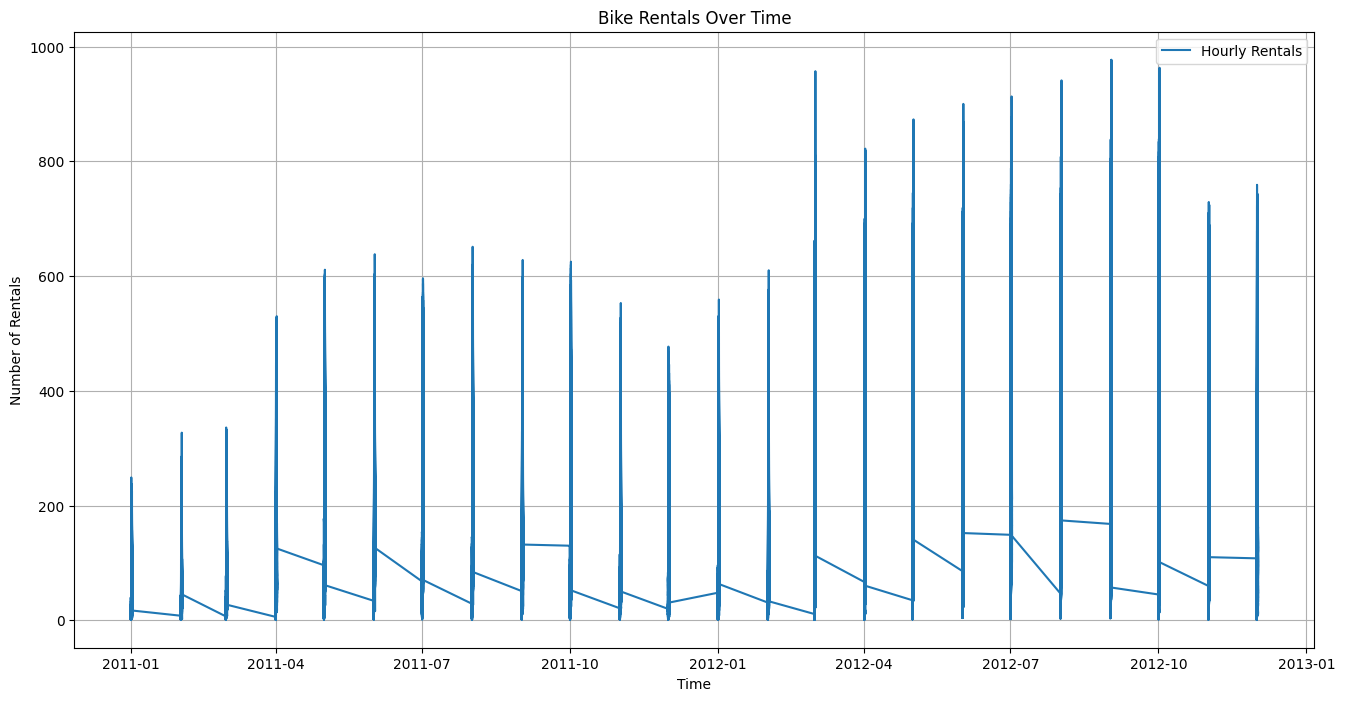

--------------------------------------------------------------------------------
Total bike rentals over the entire series: 3292679.0


In [8]:
# Plotting total bike rentals over time
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['count'], label='Hourly Rentals')
plt.title('Bike Rentals Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Rentals')
plt.legend()
plt.grid(True)
plt.show()

print('-'*80)
# Calculating total rentals
total_rentals = df['count'].sum()
print(f'Total bike rentals over the entire series: {total_rentals}')

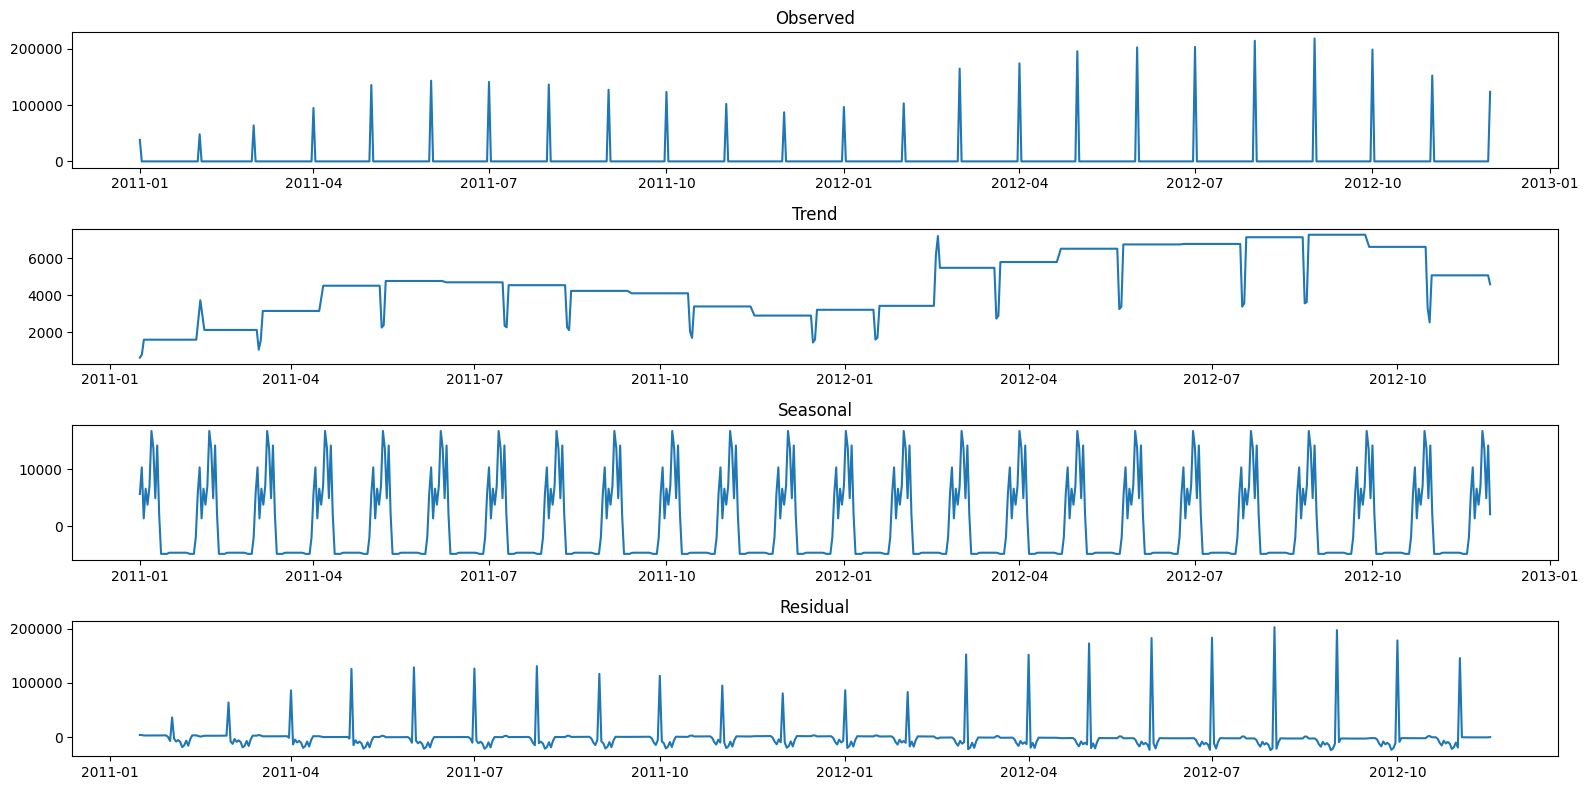

In [9]:
#Daily series resample
daily_rentals = df['count'].resample('D').sum()

#Decompose the time series
result = seasonal_decompose(daily_rentals, model='additive', period=30)

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(result.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(result.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(result.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

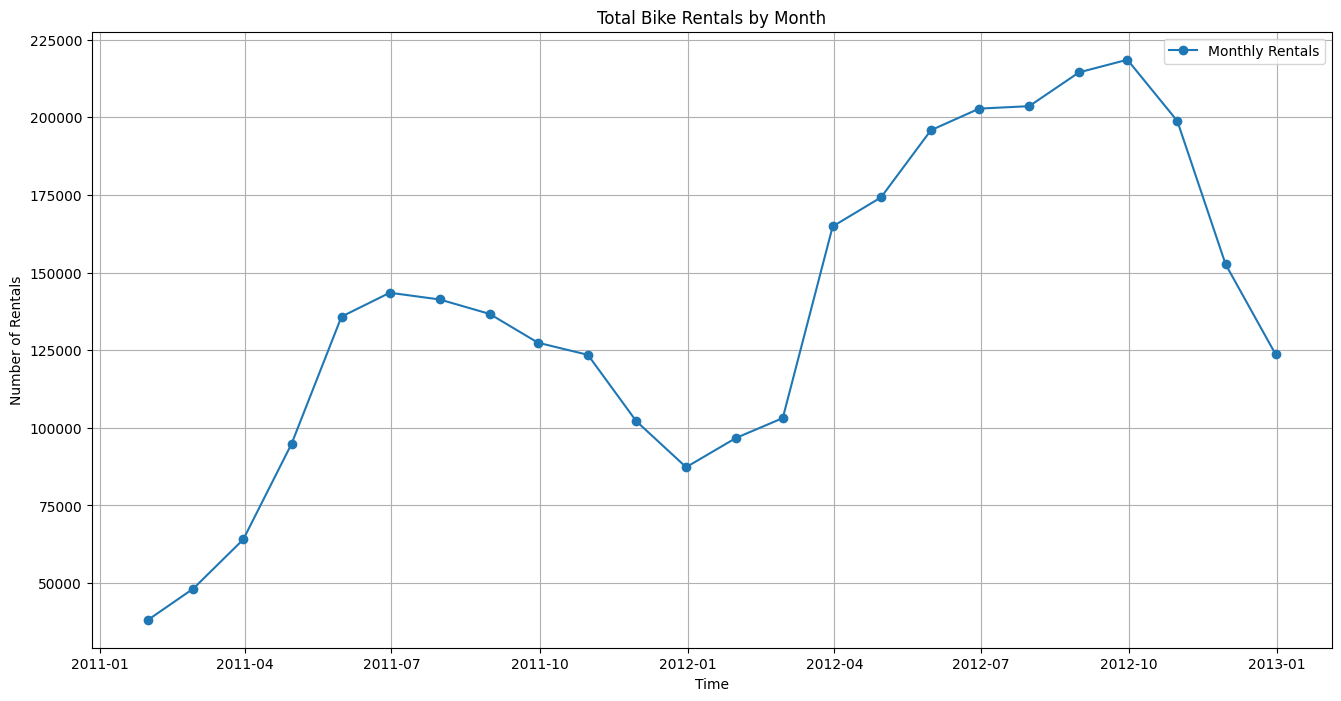

In [10]:
# Group by year and month and calculate the total rentals for each month
monthly_rentals = df['count'].resample('M').sum()

# Plotting total bike rentals over time by month
plt.figure(figsize=(16, 8))
plt.plot(monthly_rentals.index, monthly_rentals, label='Monthly Rentals', marker='o')
plt.title('Total Bike Rentals by Month')
plt.xlabel('Time')
plt.ylabel('Number of Rentals')
plt.legend()
plt.grid(True)
plt.show()

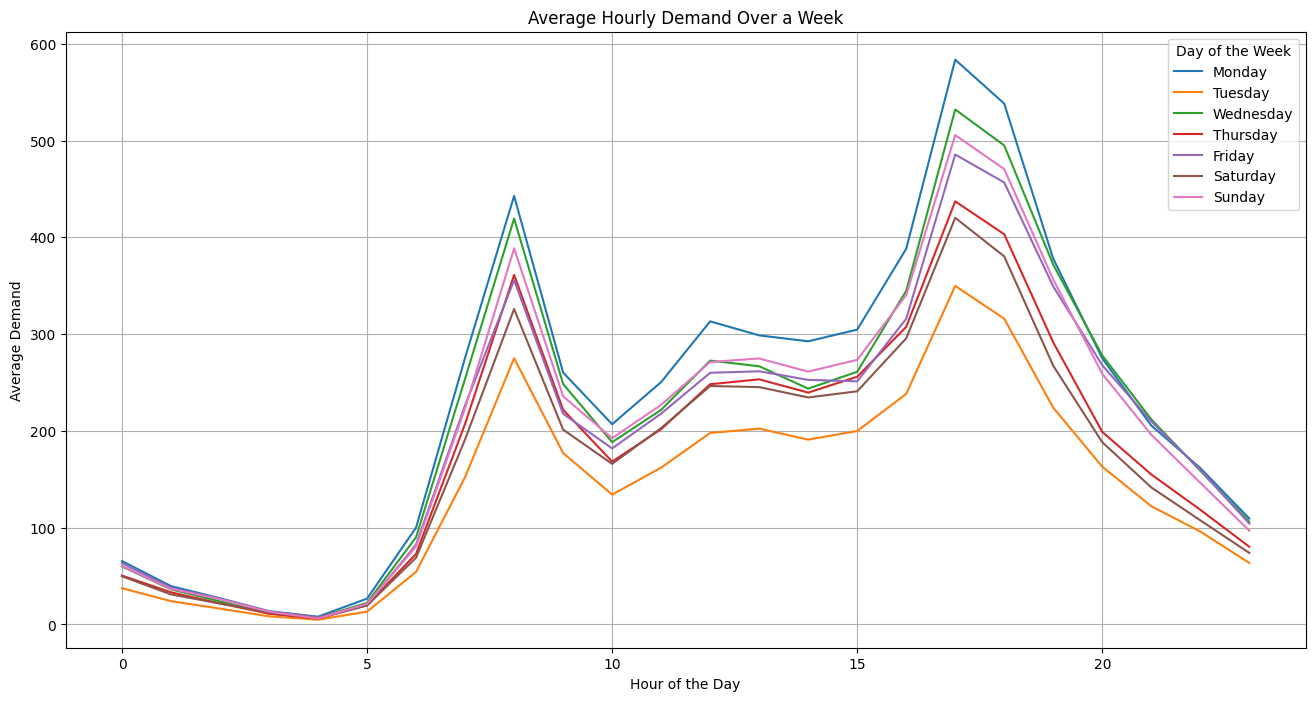

In [11]:
# Adding weekday and hour columns for grouping
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

# Group by weekday and hour and calculate the mean count
average_hourly_demand = df.groupby(['weekday', 'hour'])['count'].mean().unstack()

# Plotting the average hourly demand
plt.figure(figsize=(16, 8))
plt.plot(average_hourly_demand.T)
plt.title('Average Hourly Demand Over a Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Demand')
plt.legend(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], title='Day of the Week')
plt.grid(True)
plt.show()

In [12]:
print(df.isnull().sum())

season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
feel_temp     0
humidity      0
windspeed     0
count         0
dtype: int64


In [13]:
#We scale the target variable to be predicted ('cnt') to predict the relative demand, so the mean absolute error will be interpreted more easily.
scale_factor = df["count"].max()
y = df["count"] / scale_factor
X = df.drop(columns=['count'])
print(y)

datetime
2011-01-01 00:00:00    0.016377
2011-01-01 01:00:00    0.040942
2011-01-01 02:00:00    0.032753
2011-01-01 03:00:00    0.013306
2011-01-01 04:00:00    0.001024
                         ...   
2012-12-01 19:00:00    0.121801
2012-12-01 20:00:00    0.091095
2012-12-01 21:00:00    0.092119
2012-12-01 22:00:00    0.062436
2012-12-01 23:00:00    0.050154
Name: count, Length: 17379, dtype: float64


In [14]:
X['season'].value_counts()

fall      4496
summer    4409
spring    4242
winter    4232
Name: season, dtype: int64

In [15]:
X['weather'].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

In [16]:
#As there are very few values ​​of the 'heavy_rain' category, they are added to the 'train' category within the ['weather'] variable.
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)
X['weather'].value_counts()

clear    11413
misty     4544
rain      1422
Name: weather, dtype: int64

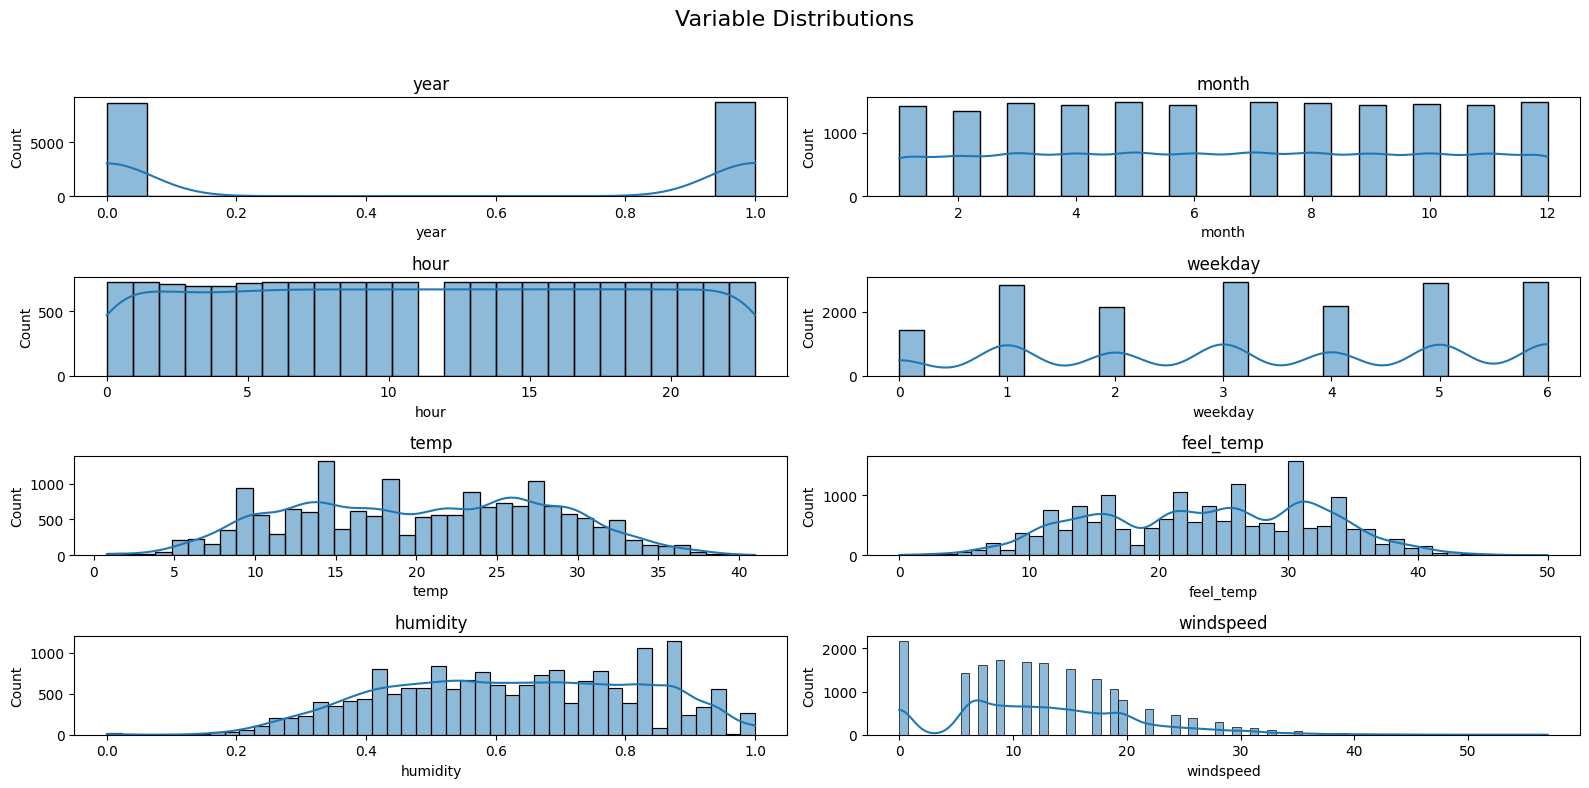

In [17]:
#Plots for the distributions of each of the numerical variables in the dataset
plt.figure(figsize=(16, 8))
plt.suptitle('Variable Distributions', fontsize=16)

# Select numerical columns from the dataframe
num_columns = X.select_dtypes(include=['float64', 'int64']).columns
n_rows = (len(num_columns) + 1) // 2
n_cols = 2

for i, column in enumerate(num_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(column)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [18]:
#The functions to transform the variables (sin/cos/spline) to be tested and the evaluate function are defined.
#Different transformation methods will be tested on the categorical variables in the different models to see the performance of each one.
#For the rest of the variables, the 'MinMaxScaler' will be tested in the first instance (for the 'simpler' models) and for the more 
#complex models different scaling methods (MinMaxScaler, StandardScaler and RobustScaler)

#Sin/cos transformer
def sin_transformer(period):
    return lambda x: np.sin(2 * np.pi * x / period)

def cos_transformer(period):
    return lambda x: np.cos(2 * np.pi * x / period)

#Cyclic transformer
def cyclic_features(X):
    X = X.copy()
    X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
    X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)
    X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
    X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
    return X

# Cyclic spline transformer
def periodic_spline_transformer(period, n_splines=None, degree=3):
    n_splines = period if n_splines is None else n_splines
    return SplineTransformer(
        degree=degree,
        n_knots=n_splines + 1,
        knots=np.linspace(0, period, n_splines + 1).reshape(-1, 1),
        extrapolation='periodic',
        include_bias=True)

#Evaluation function for models
def evaluate(model, X, y, cv):
    cv_results = cross_validate(model, X, y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])
    mae = -cv_results['test_neg_mean_absolute_error']
    rmse = -cv_results['test_neg_root_mean_squared_error']
    print(f'Mean Absolute Error: {mae.mean():.3f} +/- {mae.std():.3f}\nRoot Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}')
    print('-' * 80)
    return mae.mean(), rmse.mean()
    
    

In [19]:
#TimeSeriesSplit for cross-validation
#We divide the dataset into cross validation (5) for time series (maintaining temporal coherence), with this method we will have different 
# error metrics in training and the average will be performed

ts_cv = TimeSeriesSplit(n_splits=5, #train/test partitions
    gap=48, #48h gap between train/test partition
    max_train_size=10000, #Size limit for train/test
    test_size=1000)

Model Naive Linear Pipeline errors:

Mean Absolute Error: 0.143 +/- 0.015
Root Mean Squared Error: 0.184 +/- 0.020
--------------------------------------------------------------------------------
Model One-hot Linear Pipeline errors:

Mean Absolute Error: 0.100 +/- 0.008
Root Mean Squared Error: 0.135 +/- 0.011
--------------------------------------------------------------------------------
Model Cyclic Cos-Sin Linear Pipeline errors:

Mean Absolute Error: 0.128 +/- 0.011
Root Mean Squared Error: 0.166 +/- 0.017
--------------------------------------------------------------------------------


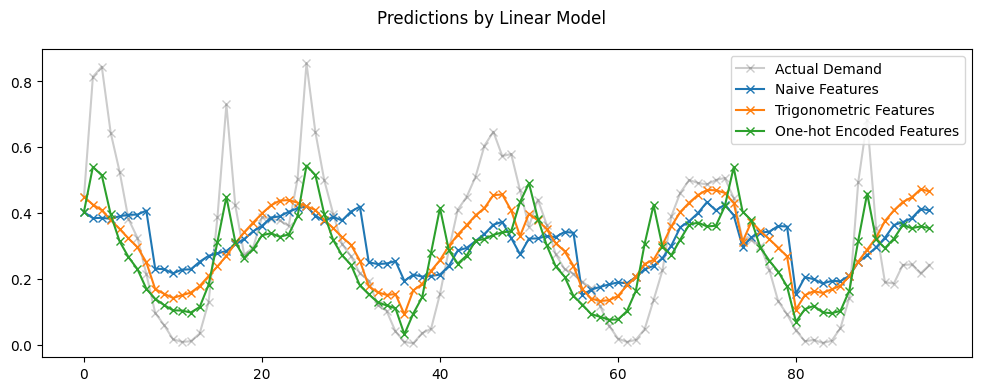

In [20]:
#One-hot encoder and categorical columns
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_columns = ['weather', 'season', 'holiday', 'workingday']

#Naive linear pipeline
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[('categorical', one_hot_encoder, categorical_columns)],
        remainder=MinMaxScaler()),
    LinearRegression())

print('Model Naive Linear Pipeline errors:\n')
evaluate(naive_linear_pipeline, X, y, cv=ts_cv)
dump(naive_linear_pipeline, '/Users/nfanlo/dev/technical-test/part2/models/naive_linear_pipeline.joblib')

#One-hot linear pipeline
one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('categorical', one_hot_encoder, categorical_columns),
            ('one_hot_time', one_hot_encoder, ['hour', 'weekday', 'month'])],
        remainder=MinMaxScaler()),
    LinearRegression())

print('Model One-hot Linear Pipeline errors:\n')
evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)
dump(one_hot_linear_pipeline, '/Users/nfanlo/dev/technical-test/part2/models/one_hot_linear_pipeline.joblib')

#Cyclic cos-sin transformer pipeline
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ('categorical', one_hot_encoder, categorical_columns),
        ('month_sin', 'passthrough', ['month']),
        ('month_cos', 'passthrough', ['month']),
        ('weekday_sin', 'passthrough', ['weekday']),
        ('weekday_cos', 'passthrough', ['weekday']),
        ('hour_sin', 'passthrough', ['hour']),
        ('hour_cos', 'passthrough', ['hour'])],
    remainder=MinMaxScaler())

X_cyclic = cyclic_features(X)

cyclic_cossin_linear_pipeline = make_pipeline(cyclic_cossin_transformer, LinearRegression())

print('Model Cyclic Cos-Sin Linear Pipeline errors:\n')
evaluate(cyclic_cossin_linear_pipeline, X_cyclic, y, cv=ts_cv)
dump(cyclic_cossin_linear_pipeline, '/Users/nfanlo/dev/technical-test/part2/models/cyclic_cossin_linear_pipeline.joblib')

#Plot the predictions for all models
train_0, test_0 = next(ts_cv.split(X, y))

naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])

one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])

cyclic_cossin_linear_pipeline.fit(X_cyclic.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X_cyclic.iloc[test_0])

last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle('Predictions by Linear Model')
ax.plot(y.iloc[test_0].values[last_hours], 'x-', alpha=0.2, label='Actual Demand', color='black')
ax.plot(naive_linear_predictions[last_hours], 'x-', label='Naive Features')
ax.plot(cyclic_cossin_linear_predictions[last_hours], 'x-', label='Trigonometric Features')
ax.plot(one_hot_linear_predictions[last_hours], 'x-', label='One-hot Encoded Features')
ax.legend()
plt.show()


In [21]:
# Function to perform GridSearchCV, fit, evaluate and save the best model
def train_and_save_model(pipeline, params, X, y, cv, model_name):
    grid_search = GridSearchCV(pipeline, params, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error')
    grid_search.fit(X, y)
    mae, rmse = evaluate(grid_search.best_estimator_, X, y, cv)
    dump(grid_search.best_estimator_, f'/Users/nfanlo/dev/technical-test/part2/models/{model_name}.joblib')
    return grid_search.best_estimator_, mae, rmse

#For complex models we gonna use onehotencoder ['weather', 'season', 'holiday', 'workingday'] 
# and spline transformer for the rest one ['month', 'weekday', 'hour]
#For the rest of the variables, the pipeline will iterate over the different scalers defined in the following notebook cell
def create_transformer(scaler):
    return ColumnTransformer(
        transformers=[
            ('categorical', one_hot_encoder, categorical_columns),
            ('cyclic_month', periodic_spline_transformer(12, 6), ['month']),
            ('cyclic_weekday', periodic_spline_transformer(7, 3), ['weekday']),
            ('cyclic_hour', periodic_spline_transformer(24, 12), ['hour'])],
        remainder=scaler)

#Function to predicting 100 time future instances
def predict_future(model, X, steps=100):
    X_future = X.iloc[-1:].copy()
    predictions = []
    for _ in range(steps):
        pred = model.predict(X_future)
        predictions.append(pred[0])
        X_future = X_future.shift(-1)
        X_future.iloc[-1, X.columns.get_loc('count')] = pred[0]
    return predictions

In [22]:
#Define the different scalers to try
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]

#Models to fit and hyperparameters
models = [
    ('Random Forest', RandomForestRegressor(n_jobs=-1), {
        'randomforestregressor__n_estimators': [100, 200, 500],
        'randomforestregressor__max_depth': [10, 20, None],
        'randomforestregressor__min_samples_split': [2, 5, 10]}),
    ('Support Vector Regressor', SVR(), {
        'svr__kernel': ['rbf', 'poly'],
        'svr__C': [0.1, 1, 10],
        'svr__epsilon': [0.01, 0.1, 1],
        'svr__degree': [2, 3, 4]}),
    ('XGBoost', XGBRegressor(n_jobs=-1), {
        'xgbregressor__n_estimators': [500, 1000, 2000],
        'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
        'xgbregressor__max_depth': [3, 5, 7]})]

best_model = None
best_mae = float('inf')
best_rmse = float('inf')

for scaler in scalers:
    for model_name, model, params in models:
        pipeline = make_pipeline(create_transformer(scaler), model)
        print(f'Model {model_name} with {scaler.__class__.__name__} errors:')
        estimator, mae, rmse = train_and_save_model(pipeline, params, X, y, ts_cv, f'{model_name}_{scaler.__class__.__name__}')
        if rmse < best_rmse:
            best_model = f'{model_name}_{scaler.__class__.__name__}'
            best_mae = mae
            best_rmse = rmse
print(f'Best model: {best_model}\nMean Absolute Error: {best_mae}\nRoot Mean Squared Error: {best_rmse}')

Model Random Forest with MinMaxScaler errors:
Mean Absolute Error: 0.055 +/- 0.010
Root Mean Squared Error: 0.084 +/- 0.012
--------------------------------------------------------------------------------
Model Support Vector Regressor with MinMaxScaler errors:
Mean Absolute Error: 0.049 +/- 0.004
Root Mean Squared Error: 0.074 +/- 0.005
--------------------------------------------------------------------------------
Model XGBoost with MinMaxScaler errors:
Mean Absolute Error: 0.049 +/- 0.002
Root Mean Squared Error: 0.073 +/- 0.004
--------------------------------------------------------------------------------
Model Random Forest with StandardScaler errors:
Mean Absolute Error: 0.055 +/- 0.010
Root Mean Squared Error: 0.084 +/- 0.013
--------------------------------------------------------------------------------
Model Support Vector Regressor with StandardScaler errors:
Mean Absolute Error: 0.050 +/- 0.002
Root Mean Squared Error: 0.075 +/- 0.003
------------------------------------

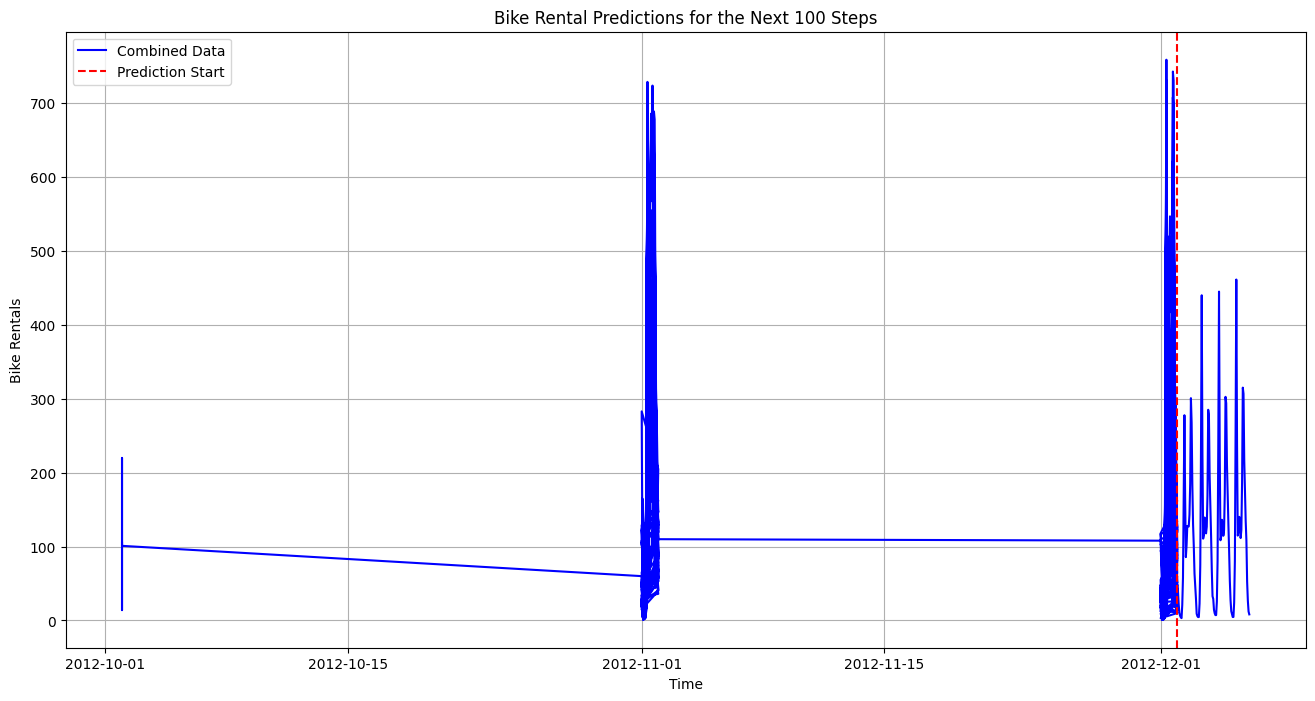

In [24]:
# Load the best model
model_path = '/Users/nfanlo/dev/technical-test/part2/models/XGBoost_MinMaxScaler.joblib'
best_model = load(model_path)

# Predicting 100 time instances into the future without future values of regressors
def predict_future(model, X, steps=100, scale_factor=1):
    last_index = X.index[-1]
    future_index = pd.date_range(start=last_index, periods=steps + 1, freq='H')[1:]  # Assuming hourly frequency
    X_future = X.iloc[-1:].copy()
    predictions = []

    for i in range(steps):
        pred = model.predict(X_future)[0]
        predictions.append(pred * scale_factor)  #Descompose prediction
        
        new_row = X_future.iloc[-1:].copy()
        new_row.index = [future_index[i]]
        new_row['hour'] = (X_future.iloc[-1]['hour'] + 1) % 24
        if new_row['hour'].iloc[0] == 0:
            new_row['weekday'] = (X_future.iloc[-1]['weekday'] + 1) % 7
            if new_row['weekday'].iloc[0] == 0:
                new_row['month'] = (X_future.iloc[-1]['month'] % 12) + 1
        X_future = X_future.append(new_row)
        X_future = X_future.drop(X_future.index[0])

    return predictions, future_index

future_predictions, future_index = predict_future(best_model, X, steps=100, scale_factor=scale_factor)

#Filter graphic for las 2 months
months_ago = X.index[-1] - pd.DateOffset(months=2)
actual_data_last_2_months = df["count"][X.index >= months_ago]

combined_index = actual_data_last_2_months.index.append(future_index)
combined_data = actual_data_last_2_months.tolist() + future_predictions

plt.figure(figsize=(16, 8))
plt.plot(combined_index, combined_data, label='Combined Data', color='blue')
plt.axvline(x=actual_data_last_2_months.index[-1], color='red', linestyle='--', label='Prediction Start')
plt.title('Bike Rental Predictions for the Next 100 Steps')
plt.xlabel('Time')
plt.ylabel('Bike Rentals')
plt.legend()
plt.grid(True)
plt.show()